In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler

# --- Database connection details ---
# DB_HOST = <YOUR DB HOST>
# DB_USER = <YOUR DB USER>
# DB_PASSWORD = <YOUR DB PASSWORD>
# DB_NAME = <YOUR DB NAME>
DB_HOST = 'localhost'
DB_USER = 'gmaayan'
DB_PASSWORD = 'j.UyNY.3NsP6vrdfy3LNq.2f'
DB_NAME = 'tweets'

In [2]:
# --- Connect to the database ---
db_connection = mysql.connector.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    charset="utf8mb4",
    collation="utf8mb4_unicode_ci"
)

# Create a cursor object
cursor = db_connection.cursor()

In [17]:
# get tweet ids
query = "SELECT id FROM tweets"
cursor.execute(query)
results = cursor.fetchall()
tweet_ids = [result[0] for result in results]
print(f'Retrieved {len(tweet_ids)} tweet ids.')

Retrieved 11934 tweet ids.


In [18]:
# get notes
placeholders = ", ".join(["%s"] * len(tweet_ids))
query = f"""SELECT 
    noteId,
    tweetId,
    classification,
    believable,
    harmful,
    misleadingOther,
    misleadingFactualError,
    misleadingManipulatedMedia,
    misleadingOutdatedInformation,
    misleadingMissingImportantContext,
    misleadingUnverifiedClaimAsFact,
    misleadingSatire,
    notMisleadingOther,
    notMisleadingFactuallyCorrect,
    notMisleadingOutdatedButNotWhenWritten,
    notMisleadingClearlySatire,
    notMisleadingPersonalOpinion
FROM notes WHERE tweetId IN ({placeholders})"""
cursor.execute(query, tweet_ids)
results = cursor.fetchall()
full_notes = pd.DataFrame(results, columns=[
    'noteId', 
    'tweetId', 
    'classification', 
    'believable', 
    'harmful', 
    'misleadingOther', 
    'misleadingFactualError', 
    'misleadingManipulatedMedia', 
    'misleadingOutdatedInformation', 
    'misleadingMissingImportantContext', 
    'misleadingUnverifiedClaimAsFact', 
    'misleadingSatire', 
    'notMisleadingOther', 
    'notMisleadingFactuallyCorrect', 
    'notMisleadingOutdatedButNotWhenWritten', 
    'notMisleadingClearlySatire', 
    'notMisleadingPersonalOpinion'
])
note_ids = [str(id) for id in list(full_notes['noteId'].unique())]
print(f'Retrieved {len(full_notes)} notes.')

Retrieved 61723 notes.


In [19]:
# get ratings for the notes
placeholders = ", ".join(["%s"] * len(note_ids))
query = f"""SELECT 
    noteId,
    raterParticipantId,
    helpfulnessLevel,
    ratedOnTweetId
FROM note_ratings WHERE noteId IN ({placeholders})"""
cursor.execute(query, note_ids)
results = cursor.fetchall()
full_ratings = pd.DataFrame(results, columns=[
    'noteId', 
    'raterParticipantId', 
    'helpfulnessLevel', 
    'ratedOnTweetId'
])
print(f'Retrieved {len(full_ratings)} ratings.')

Retrieved 29631500 ratings.


In [23]:
# get full tweets
query = f"""
SELECT 
    id,
    text,
    created_at,
    author_id,
    retweet_count,
    reply_count,
    like_count,
    quote_count,
    bookmark_count,
    impression_count,
    interaction_score,
    action_count
FROM tweets
"""
cursor.execute(query)
results = cursor.fetchall()
full_tweets = pd.DataFrame(results, columns=[
    'id', 
    'text', 
    'created_at', 
    'author_id', 
    'retweet_count', 
    'reply_count', 
    'like_count', 
    'quote_count', 
    'bookmark_count', 
    'impression_count',
    'interaction_score',
    'action_count'
])
print(f'Retrieved {len(full_tweets)} tweets.')

Retrieved 11934 tweets.


In [21]:
# calculate interaction scores and externalities


# get ratings score for the notes
ratings_map = {
    'HELPFUL': 1,
    'SOMEWHAT_HELPFUL': 0,
    'NOT_HELPFUL': -1
}

notes_map = {
    'MISINFORMED_OR_POTENTIALLY_MISLEADING': -1,
    'NOT_MISLEADING': 1,
}

full_ratings['rating_score'] = full_ratings['helpfulnessLevel'].map(ratings_map)
full_notes['note_score'] = full_notes['classification'].map(notes_map)

# calculate the sum of the ratings for each note
full_ratings['rating_score'] = full_ratings['rating_score'].fillna(0)
note_ratings = full_ratings[['noteId', 'rating_score']].groupby('noteId').sum().reset_index()

# add note_ratings to full_notes
full_notes = full_notes.merge(note_ratings, on='noteId', how='left')

# calculate the overall note score as the note score times the rating score
full_notes['externality_score'] = full_notes['note_score'] * full_notes['rating_score']

In [24]:
# add externality scores to tweets as the sum of the externality scores of the notes for each tweet
notes_score_by_tweet = full_notes[['tweetId', 'externality_score']].groupby('tweetId').sum().reset_index()
full_tweets = full_tweets.merge(notes_score_by_tweet, left_on='id', right_on='tweetId', how='left')

# filter out tweets with no impressions
full_tweets = full_tweets[full_tweets['impression_count'] > 0]

# calculate the externality as the externality score divided by the number of impressions
full_tweets['externality'] = full_tweets['externality_score'] / full_tweets['impression_count']

# add action count per 1000 impressions
full_tweets['action_count_per_1000_impressions'] = full_tweets['action_count'] / (full_tweets['impression_count'] / 1000)

# remove outlier with massive action count 
# Alina Habba tweetid: 1819110904216084953
# Drug free world tweetid: 1847181579103490414
full_tweets = full_tweets[full_tweets['action_count_per_1000_impressions'] < 150]

print(full_tweets[['interaction_score','externality', 'action_count']].describe())

       interaction_score   externality  action_count
count       1.185300e+04  11853.000000  1.185300e+04
mean        7.261223e-03     -0.000450  7.378737e+04
std         8.994813e-03      0.004584  1.593500e+05
min         4.500000e-07     -0.472590  5.000000e+00
25%         1.650212e-03     -0.000463  5.880000e+03
50%         4.360297e-03     -0.000155  2.032700e+04
75%         9.392109e-03     -0.000034  7.139900e+04
max         1.254045e-01      0.024641  5.446737e+06


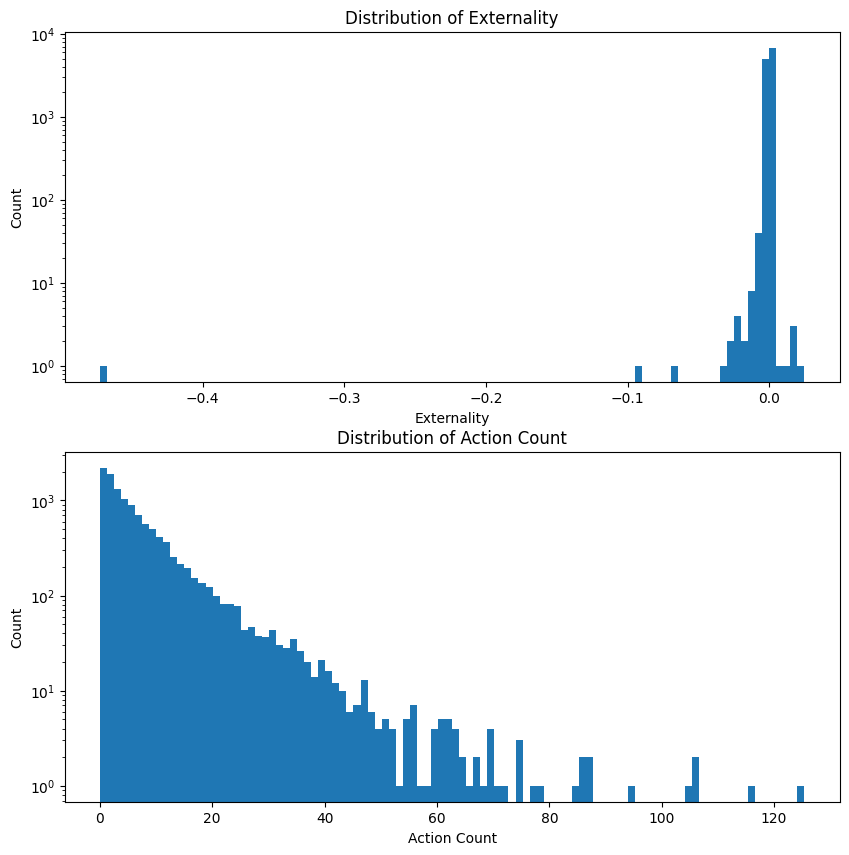

In [26]:
# plot histograms of externality cpm and action counts per 1000 impressions
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].hist(full_tweets['externality'], bins=100, log=True)
ax[0].set_xlabel('Externality')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of Externality')
ax[1].hist(full_tweets['action_count_per_1000_impressions'], bins=100, log=True )
ax[1].set_xlabel('Action Count')
ax[1].set_ylabel('Count')
ax[1].set_title('Distribution of Action Count')
plt.show()

In [14]:
print(full_tweets[['impression_count']].describe())

       impression_count
count      1.185300e+04
mean       1.388155e+07
std        2.539523e+07
min        5.290000e+02
25%        1.905037e+06
50%        5.114366e+06
75%        1.476343e+07
max        6.343875e+08


In [ ]:
full_tweets['created_at_dt'] = pd.to_datetime(full_tweets['created_at'])
date_pulled = pd.to_datetime('02/02/2025')
full_tweets['days_old'] = (date_pulled - full_tweets['created_at_dt']).dt.days
full_tweets['months_old'] = full_tweets['days_old']/30

# plot histogram of impressions per month
plt.hist(full_tweets['impression_count']/(full_tweets['days_old']/30), bins=30, log=True)
plt.xlabel('Impressions per Month')
plt.ylabel('Frequency')
plt.title('Impressions per Month Histogram')

full_tweets['impressions_per_month'] = full_tweets['impression_count']/full_tweets['months_old']

In [ ]:
# calculate the externality per 1000 impressions per month
full_tweets['ext_per_month'] = (full_tweets['externality'] *
                                       full_tweets['impressions_per_month'] / 1000)

# producer actions per month
full_tweets['actions_per_month'] = full_tweets['action_count'] / full_tweets['months_old']

print(full_tweets[['ext_dollars_per_month', 'actions_per_month']].describe())
full_tweets['v_score'] = full_tweets['actions_per_month']
full_tweets['e_score'] = full_tweets['ext_per_month']

In [27]:
# --- Clean up ---
full_tweets.to_csv('full_tweets.csv', index=False)
cursor.close()
db_connection.close()